# Notebook for plotting monthly min, mean, max, median, and standard deviation spatial climatologies

### Import necessary libraries (NetCDF4 for working with .nc files, xarray for opening .nc files, statistics for stats computations, cartopy for plotting)

In [1]:
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import statistics

## Open relevant dataset (monthly min, mean, or max)- contains 12 months of min, mean, or max values grouped across entire HIST (1990-2005) period

In [48]:
monthly_max = xr.open_dataset('/home/scratch/jgoodin/monthly_resamples/WRF_monthly_max_resample.nc') #Open .nc file from scratch directory- change file depending
#on variable being plotted, e.g., min, mean, max
monthly_max #Print out datset- make sure 12 months are returned

<xarray.Dataset>
Dimensions:     (month: 12, south_north: 899, west_east: 1399)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (month, south_north, west_east) float32 ...

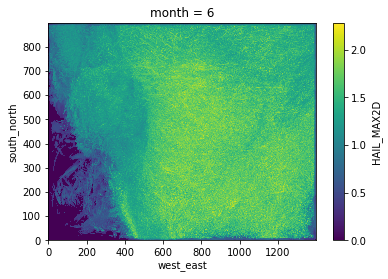

In [3]:
monthly_max.sel(month = 6).HAIL_MAX2D.plot() #Test plot one month of data- check for nan values or empty dataset

## Select HAIL_MAX2D values by month (1-12) for plotting

In [73]:
mesh = monthly_max.sel(month = 12).HAIL_MAX2D #Create variable mesh and select month = 1 (Jan), month = 2 (Feb), etc. This will be the plotting variable

## Import relevant statistical dataset containing standard deviation for 12 months grouped across entire HIST dataset

In [75]:
stdev_hail = xr.open_dataset('/home/scratch/jgoodin/monthly_resamples/WRF_monthly_stdev_resample.nc') #Open .nc file from scratch directory
stdev_hail #Print out dataset- returns 12 months

<xarray.Dataset>
Dimensions:     (month: 12, south_north: 899, west_east: 1399)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (month, south_north, west_east) float32 ...

### NOTE: Units of standard deviation are the same as the data [HAIL_MAX2D; in]. Values are squared (square root of variance), with higher values (in inches) representing a higher variance (spread) in the data

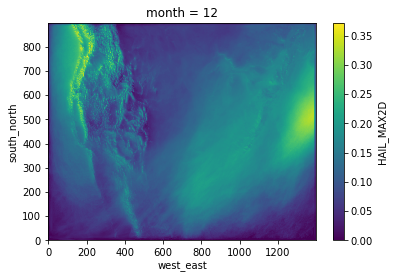

In [23]:
stdev_hail.sel(month = 12).HAIL_MAX2D.plot() #Test plot one month- dataset check, check if stdev values seem reasonable

## Select stdev HAIL_MAX2D values for plotting

In [99]:
stdev_plot = stdev_hail.sel(month = 12).HAIL_MAX2D #Create variable stdev_hail and select by month for plotting- same process as used above

### Import netcdf file containing lat/lon coords for WRF files (use this for plotting)

In [4]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

### Assign lat/lon coords from file to variables

#### Lat/lon coords contained a third dimension equal to 1, we want to get rid of this and ensure data is 2D

In [5]:
lats = coords.CLAT.values[0, :, :]
lons = coords.CLONG.values[0, :, :]

## Plot data on map of CONUS (use same map, switch plotting variables)

### Use cartopy's shapefile reader and "add_feature" tools to add land, ocean, lake polygons; state border, coastline line features

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


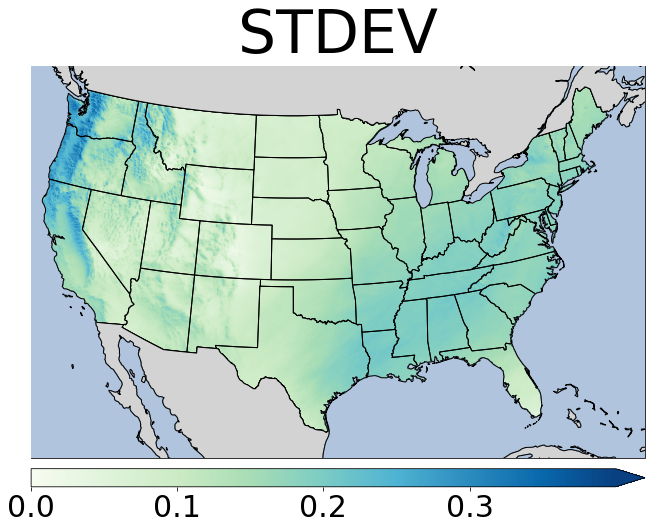

In [100]:
fig = plt.figure(figsize= (11,8)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, width_ratios = [3], height_ratios=[1, .04], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons, lats, stdev_plot, cmap = 'GnBu', vmax = 0.4, transform = ccrs.PlateCarree())
#ax.text(-125, 32, 'DEC', fontsize = 60, va='bottom', ha='center', rotation='vertical', transform=ccrs.PlateCarree())
#gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
#gls.top_labels=False
#gls.right_labels=False
#gls.xlabel_style = {'size': 18, 'rotation': 0}
#gls.xpadding = 12.0
#gls.ylabel_style = {'size': 18}
plt.title("STDEV", fontsize = 60)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, ticks = [0, 0.1, 0.2, 0.3], orientation = 'horizontal', extend = 'max')
#cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 30)
plt.subplots_adjust(bottom=0)
plt.savefig('/home/scratch/jgoodin/monthly_mesh_climos/stdev/Dec_stdev.png')